# Summary - Process Classification

1. Load data from ```process_uber_summary``` table and flag *badusers* -- we'll use "baduser" processes as positive labels, and others as negative labels
2. Build a simple random forest classifier with numerical features from that table and look at: (i) classification performance (recovering baduser processes), (ii) conditional feature distributions, and (iii) feature importance
3. Also try a simple CART model
4. Explore Sigma labels for classification purpose
5. Try classification aimed at recovering "negative labels" (for filtering purpose)


# Introduction

The first few cells are taken from BH's ```process-name-curation``` notebook


In [1]:
%load_ext autoreload
%load_ext dotenv
#%load_ext quak 
%load_ext sql

Tip: You may define configurations in /work/home/fcthebe/Acme4/Wintap-Analytics/2025-acme4-explore/pyproject.toml or /work/home/fcthebe/.jupysql/config.

Did not find user configurations in /work/home/fcthebe/Acme4/Wintap-Analytics/2025-acme4-explore/pyproject.toml.

In [2]:
%autoreload 1
%aimport acme4_explore

In [3]:
%dotenv

In [4]:
%%time
import acme4_explore
import datamapplot as dmp
from fast_hdbscan import HDBSCAN
import io
import json
import logging as lg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sentencepiece import SentencePieceTrainer, SentencePieceProcessor
from sklearn.metrics.pairwise import paired_distances
from tqdm.auto import tqdm, trange
import umap
import vectorizers as vz
import vectorizers.transformers as vzt
import zstandard as zstd

import seaborn as sns
from collections import Counter

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.inspection import permutation_importance

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


CPU times: user 30.3 s, sys: 3.68 s, total: 34 s
Wall time: 30.8 s


In [5]:
# Registers the current `tqdm` class with pandas.core.
tqdm.pandas()


In [6]:
lg.basicConfig(**acme4_explore.logging_config())
LOG = lg.getLogger("notebook")


In [7]:
db = acme4_explore.connect_db()
%sql db --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True


# (1) Get data from the ```process_uber_summary``` table

* Flag processes from "badusers"
* Drop some numerical features too closely correlated with the baduser label


In [8]:
%%sql process <<
select * from process_uber_summary


In [9]:
# number of unique PIDs
print(process.shape)
len(set(process['pid_hash']))


(1772966, 130)


1772947

In [10]:
## numerical features
num_col = process.select_dtypes(include=np.number).columns.tolist()
# drop those - bad user's activity is limited in time
num_col.remove('process_started_seconds')
num_col.remove('process_stop_seconds')
# also drop
num_col.remove('parent_os_pid')
num_col.remove('os_pid')
num_col.remove('token_elevation_type')

## flag 'badusers'
process['is_bad'] = 0
process.loc[process["user_name"].isna(), "user_name"] = ""
process.loc[process["user_name"].str.contains("baduser") , "is_bad"] = 1
process.loc[process["user_name"]=="", "user_name"] = '<NA>'
process.is_bad.value_counts()


is_bad
0    1771882
1       1084
Name: count, dtype: int64

In [11]:
## bad users - most common processes
process[process.is_bad==1].groupby(by='process_name')['is_bad'].sum().sort_values(ascending=False).head(10)


process_name
msedge.exe           325
firefox.exe          125
cleanmgr.exe          85
dismhost.exe          82
dllhost.exe           60
conhost.exe           37
runtimebroker.exe     34
svchost.exe           30
smartscreen.exe       25
taskhostw.exe         24
Name: is_bad, dtype: int64

In [12]:
## bad users - most common filenames
Counter(process[process.is_bad==1].filename).most_common(5)

[('c:\\program files (x86)\\microsoft\\edge\\application\\msedge.exe', 325),
 ('c:\\program files\\mozilla firefox\\firefox.exe', 125),
 ('c:\\windows\\system32\\cleanmgr.exe', 85),
 ('c:\\windows\\system32\\dllhost.exe', 58),
 ('c:\\windows\\system32\\conhost.exe', 37)]

# (2) Random forest classification model 

Typical classification task with:
* 50/50 split for training and testing
* Report performance via confusion matrix, AUC and ROC curve
* Permutation-based feature importance (a la L. Breiman)
* A posteriori, look at feature distributions conditioned on the baduser label

Observations:
* Remarkable ROC curve and AUC value
* Confusion matrix indicates tclassification could also be used to filter most "non-badusers"
* Several top featuers involve the sigma labels
* ...


In [13]:
## simple random forest
X = process[num_col]
y = process['is_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
rf = RandomForestClassifier(n_jobs=25)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


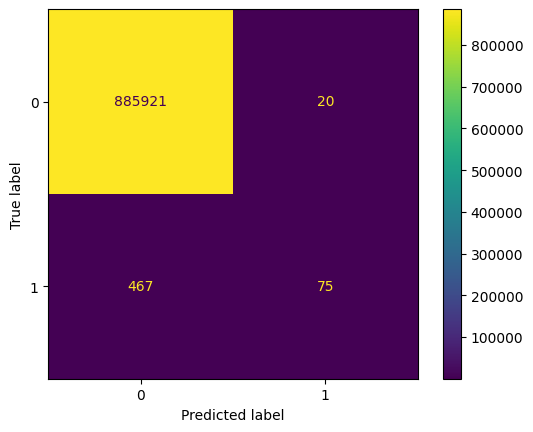

In [14]:
## confusion matrix
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)
disp.plot()
plt.show()


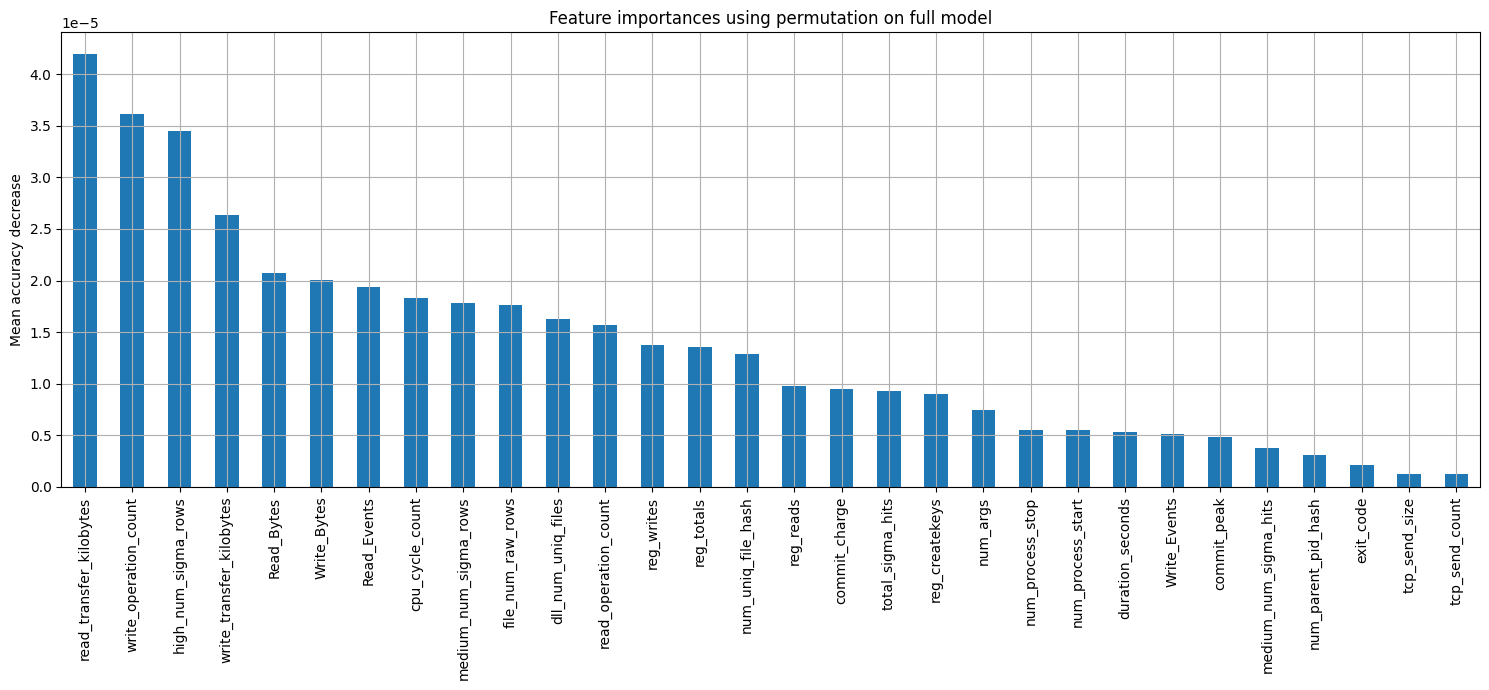

In [15]:
## variable permutation importance -- this takes a few minutes
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=16
)

## plot top ones
_top = 30
forest_importances = pd.Series(result.importances_mean, index=num_col).sort_values(ascending=False)[:_top]
fig, ax = plt.subplots(figsize=(15,7))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.grid()
plt.show()


AUC:, 0.9821538129297683


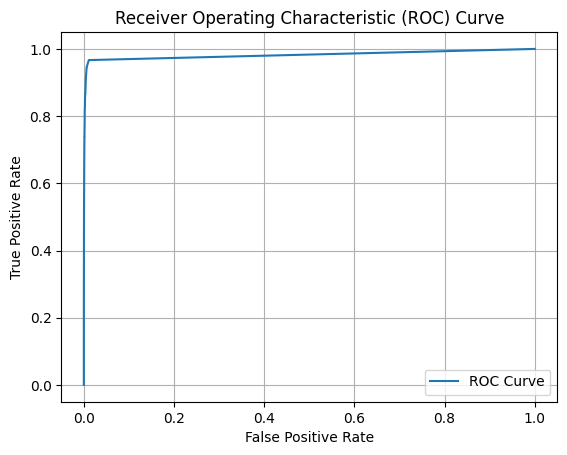

In [16]:
## AUC and ROC curve
y_pred_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
print('AUC:,',auc(fpr, tpr))

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()


/work/home/fcthebe/Acme4/Wintap-Analytics/2025-acme4-explore/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/work/home/fcthebe/Acme4/Wintap-Analytics/2025-acme4-explore/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/work/home/fcthebe/Acme4/Wintap-Analytics/2025-acme4-explore/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/work/home/fcthebe/Acme4/Wintap-Analytics/2025-acme4-explore/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/work/home/fcthebe/Acme4/Wintap-Analytics/2025-acme4-explore/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:465

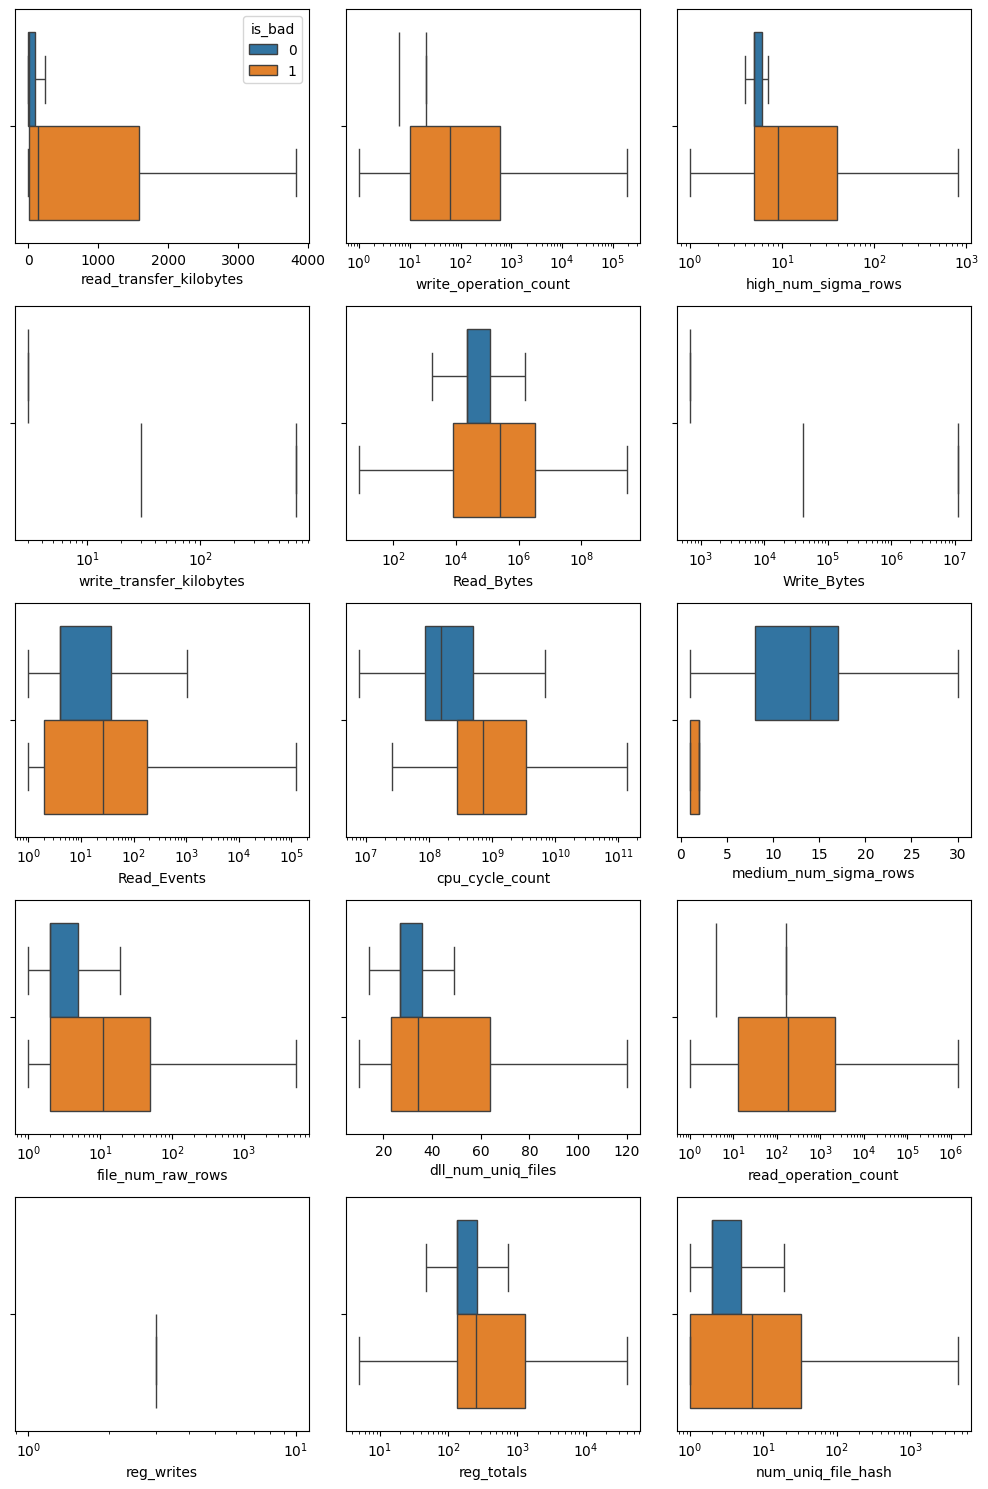

In [17]:
## numerical columns -- conditional distribution
fig, axes = plt.subplots(5,3, figsize=(10, 15))
ctr = 0
for col in list(forest_importances.keys())[:15]:
    if ctr==0:
        sns.boxplot(data=process, x=col, hue='is_bad', showfliers=False, ax=axes[ctr//3,ctr%3])
    else:
        if max(process[col].dropna()) > 1e4:
            sns.boxplot(data=process, x=col, hue='is_bad', showfliers=False, ax=axes[ctr//3,ctr%3], legend=False, log_scale=True)
        else:
            sns.boxplot(data=process, x=col, hue='is_bad', showfliers=False, ax=axes[ctr//3,ctr%3], legend=False, log_scale=False)
    ctr+=1
plt.tight_layout()
plt.show()


# (3) A simple CART classification model

In view of the above results, we try a simple, very interpretable classification tree using the same approach.

We can actually visualize the top splits in the tree.

Results from the confusion matrix are only slightly worse that with a random forest.


In [18]:
## Fit the model
from sklearn.tree import DecisionTreeClassifier

# Create a DecisionTreeClassifier instance
cart = DecisionTreeClassifier(random_state=321, max_depth=6)

# Train the classifier
cart.fit(X_train, y_train)

# Make predictions
y_pred = cart.predict(X_test)


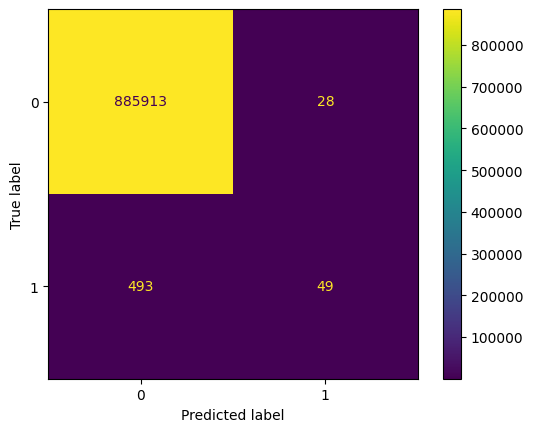

In [19]:
## Confusion matrix
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)
disp.plot()
plt.show()


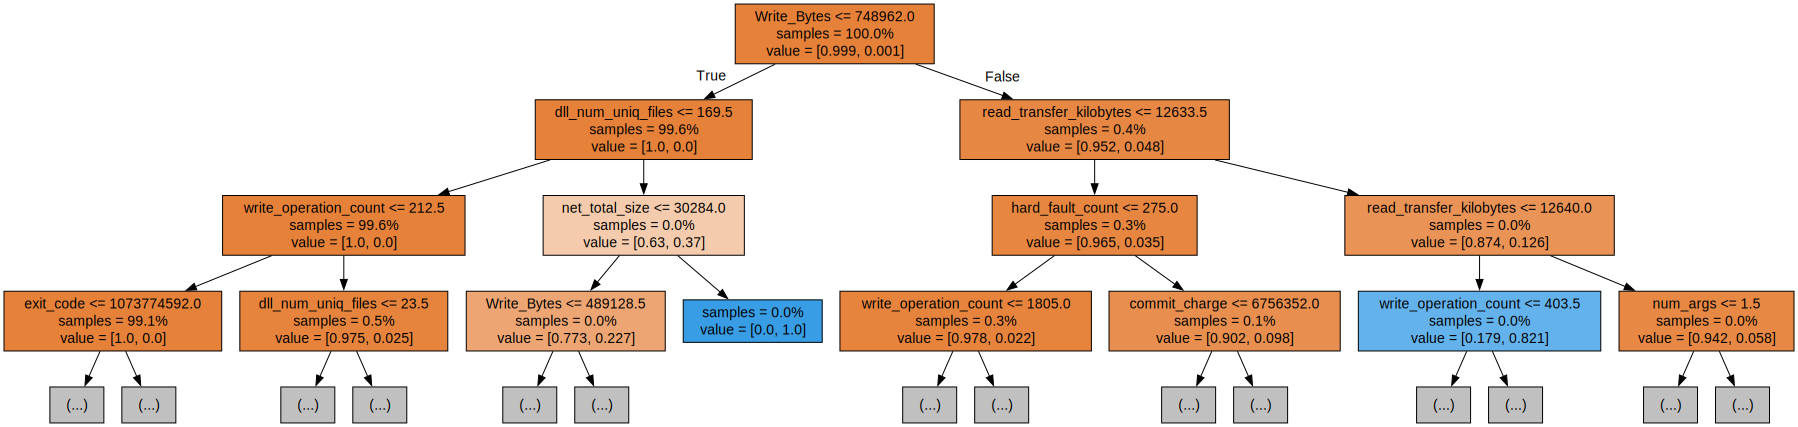

In [20]:
dot_data = export_graphviz(cart,
                           feature_names=X_train.columns,  
                           filled=True,  
                           max_depth=3, 
                           impurity=False, 
                           proportion=True)
graph = graphviz.Source(dot_data)
display(graph)


# (4) Exploring the sigma labels

The Mitre labels do not appear helpful for this classification task, but sigma labels appear in top features, so we expand on those.
We gather those from the ```sigma_labels``` table.

Observations:
* a simple sum of the number of sigma "events" does well at discriminating badusers ; this aligns with the fact that feature ```high_num_sigma_rows``` is amongst the top in importance for supervised learning
* some sigma analytics are very common ; summing 1/frequency instead for the sigma events does a bit better


In [21]:
%%sql sigma <<
select * from sigma_labels


In [22]:
## some sigma ids are very common!
Counter(sigma.analytic_id).most_common(5)


[('4fc0deee-0057-4998-ab31-d24e46e0aba4', 12303554),
 ('f208d6d8-d83a-4c2c-960d-877c37da84e5', 5501388),
 ('71158e3f-df67-472b-930e-7d287acaa3e1', 5042822),
 ('9d7ca793-f6bd-471c-8d0f-11e68b2f0d2f', 1925188),
 ('e4a6b256-3e47-40fc-89d2-7a477edd6915', 594966)]

### compute scores 

sum of counts and sum of inverse frequencies

the cell below takes a few minutes to run - could try to parallelize with dask


In [23]:
%%time

## add counts (1/frequency and 1) 
_sigma_dict = sigma["analytic_id"].value_counts().to_dict()
sigma['score_inv_freqs'] = [1/_sigma_dict[x] for x in sigma.analytic_id]
sigma['score_counts'] = 1

## merge with process dataframe and compute scores (sum of counts and sum of inverse frequencies)
_temp = pd.merge(process, sigma, left_on='pid_hash', right_on='entity', how='inner')[['pid_hash','is_bad','score_inv_freqs','score_counts']]
sigma = _temp.groupby(by='pid_hash').sum()
sigma['is_bad'] = sigma.is_bad>0
sigma.head(5)


CPU times: user 48.1 s, sys: 2min 46s, total: 3min 35s
Wall time: 3min 34s


,is_bad,score_inv_freqs,score_counts
pid_hash,,,
000001EA39466E3FB91366E47D7C96C9,False,4.063866e-07,5
00000CE18D05E89D614D0C0C0E6F271B,False,3.800740e-07,2
00000F8E6D0244A31216546667930CCF,False,4.063866e-07,5
0000251FFF585B0D0596C9C802C836E0,False,4.063866e-07,5
0000312235C982867A2485C9BA3AEC3E,False,2.385952e-06,7


### using the counts score as sole predictor

this is clearly better than random, with a number of "early hits" on the ROC curve


AUC:, 0.8004815312142949


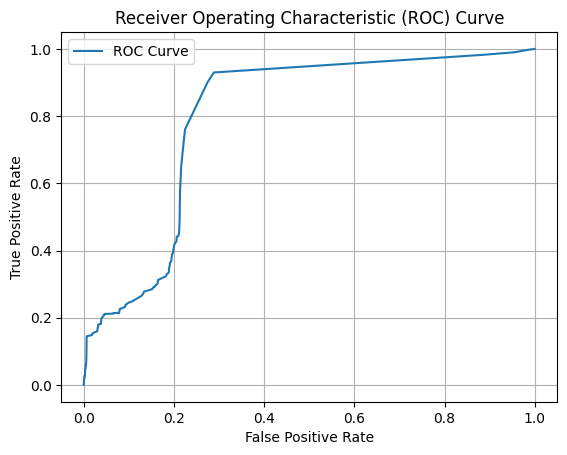

In [24]:
fpr, tpr, thresholds = roc_curve(sigma.is_bad, sigma.score_counts)
print('AUC:,',auc(fpr, tpr))
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()


### using the inverse frequencies score as sole predictor

this is even better than random, with a lot of "early hits" on the ROC curve and higher AUC

next we try to add this feature to our earlier random forest model


AUC:, 0.8767430802794933


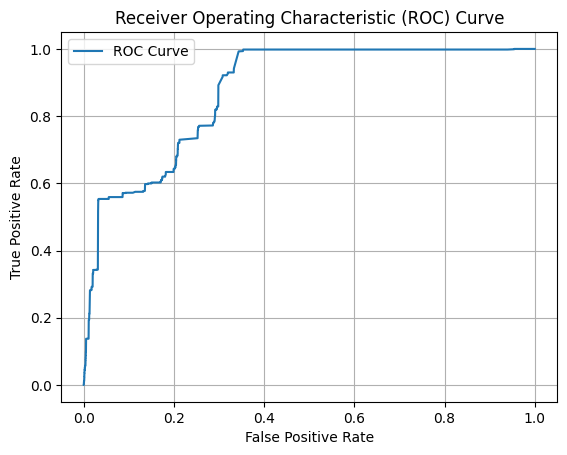

In [25]:
fpr, tpr, thresholds = roc_curve(sigma.is_bad, sigma.score_inv_freqs)
print('AUC:,',auc(fpr, tpr))
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()


### Adding the inverse frequency sigma-based feature to our simple forest model

ROC curve is almost the same, but we see the inverse frequency score as the second most important feature.


In [26]:
num_col.append('score_inv_freqs')
process = pd.merge(process, sigma, left_on='pid_hash', right_on='pid_hash', how='inner', suffixes=['_dup',None])

## simple random forest
X = process[num_col]
y = process['is_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
rf = RandomForestClassifier(n_jobs=25)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


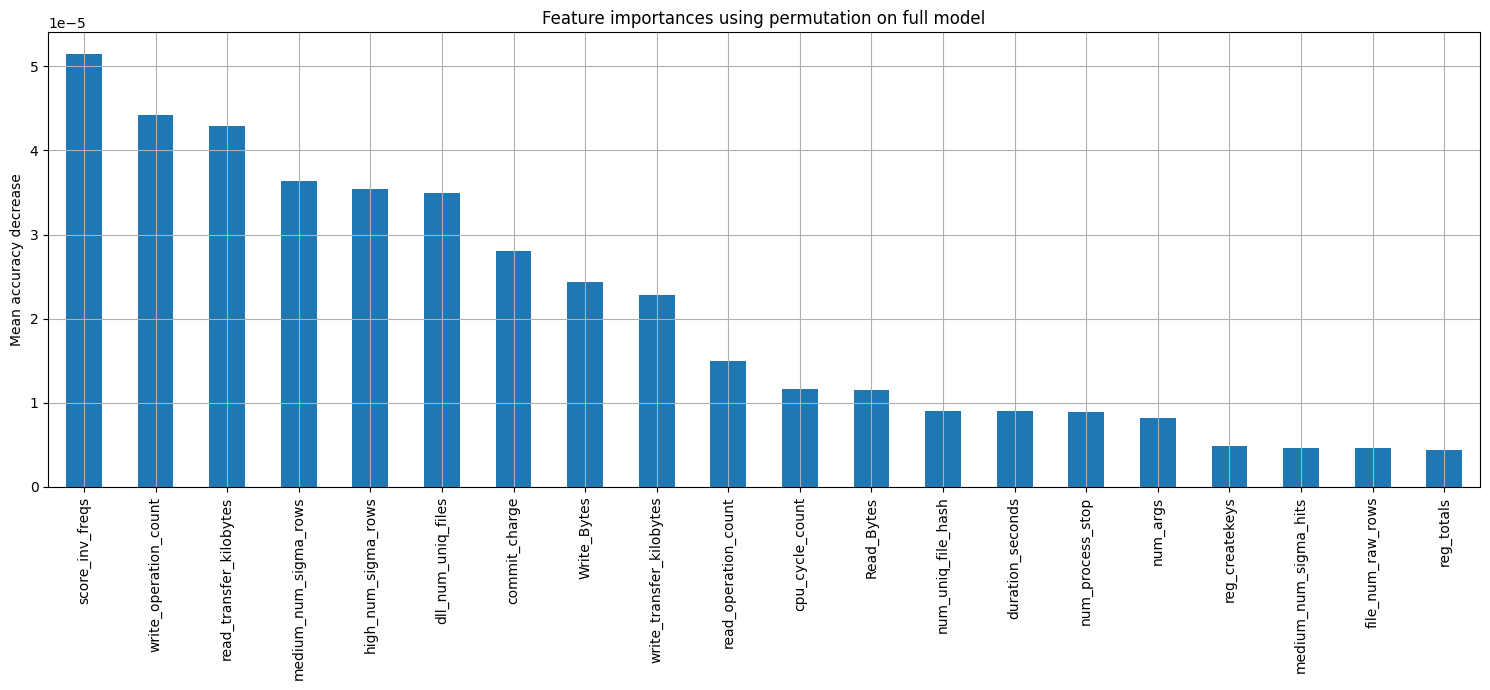

In [27]:
## variable importance
result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=16
)

## plot top ones
_top = 20
forest_importances = pd.Series(result.importances_mean, index=num_col).sort_values(ascending=False)[:_top]
fig, ax = plt.subplots(figsize=(15,7))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.grid()
plt.show()


AUC:, 0.972897655726578


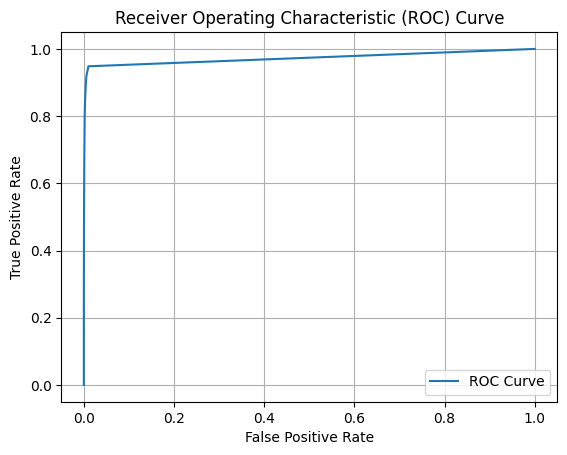

In [28]:
## ROC and AUC
y_pred_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
print('AUC:,',auc(fpr, tpr))

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()


### Model with top features only

We see a drop in FI after the top-6 ; let's try using only those ...

We still get a very good ROC curve with only a few predictors.


In [29]:
## top-6
num_col_subset = forest_importances.keys()[:6].tolist()

## simple random forest
X = process[num_col_subset]
y = process['is_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
rf = RandomForestClassifier(n_jobs=25)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


AUC:, 0.9315665128688707


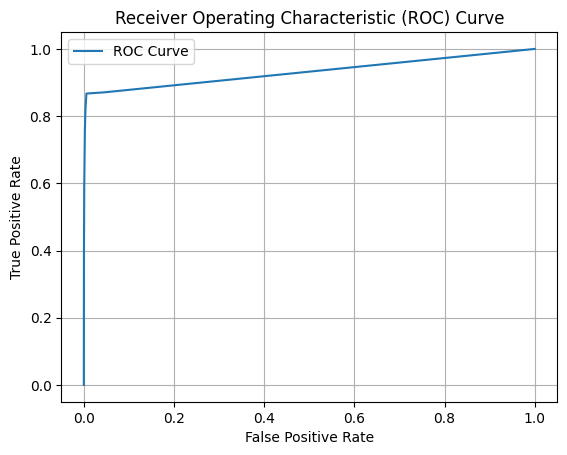

In [30]:
y_pred_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
print('AUC:,',auc(fpr, tpr))

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()


# (5) Reverse the labels - try dropping "ok stuff"

This is really the same model, but we look at the confusion matrix for the angle of dropping "non-bad" processes.

Adjusting the threshold, we can remove most "non-bad" while retaining a large proportion of the baduser processes.


In [31]:
## simple random forest
X = process[num_col]
y = [not x for x in process['is_bad']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
rf = RandomForestClassifier(n_jobs=25)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


AUC:, 0.9821583671189479


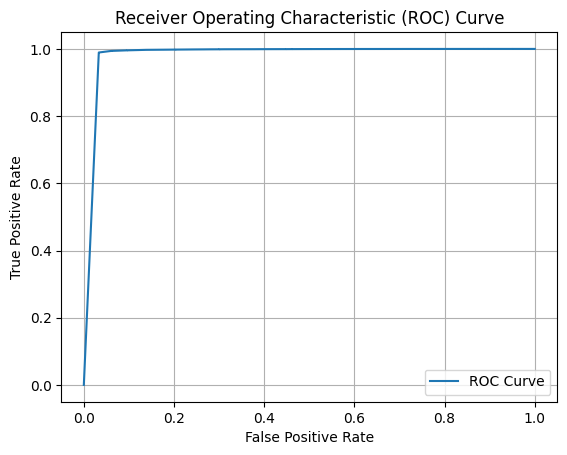

In [32]:
y_pred_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
print('AUC:,',auc(fpr, tpr))

plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()


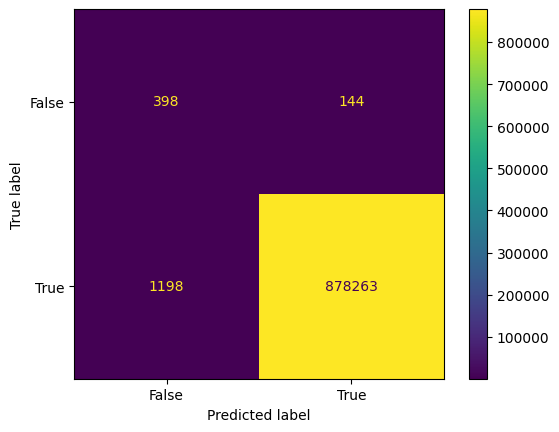

In [33]:
## high threshold
y_pred = y_pred_proba > .90
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)
disp.plot()
plt.show()


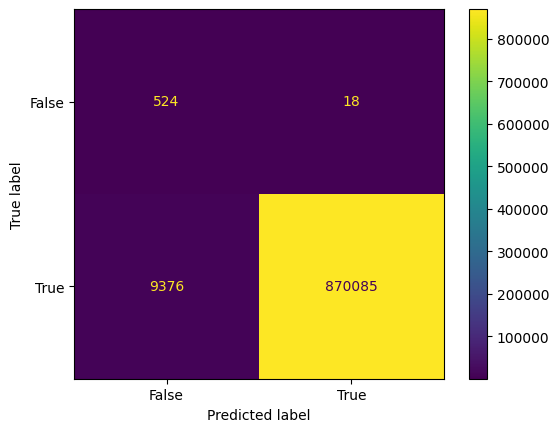

In [34]:
## very high threshold
y_pred = y_pred_proba > .99
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)
disp.plot()
plt.show()
